# Tips & Trics for anypytools

## Stopping and restarting simulations

AnyPyProcess caches the simulation results. This allows us to stop the simulations, and then later restart them again.

In [1]:
from anypytools import AnyPyProcess, macro_commands as mc
app = AnyPyProcess(num_processes=2)

macrolist = []
for i in range(20):
    macro = [
        mc.Load("Knee.any"),
        mc.RunOperation("Main.MyStudy.InverseDynamics")
    ]
    macrolist.append(macro)


In [2]:
app.start_macro(macrolist); 

Output()

KeyboardInterrupt: User aborted
Completed: 15, Not processed: 5


Here we stopped the simulation using the Notebook interrupt button. Calling the `start_macro()` function again continues the processing and re-run any task that wasn't completed in the first run and any task that exited with errors. 

In [3]:
app.start_macro(macrolist);

Output()

Completed: 20


Note: That changing the input arguments `start_macro` or re-instanciating the `app` object will erase the cache and re-run all processes. 


## Including meta-information in the output

The `start_macro()` also returns extra meta info, but the information is not printed by the default `__repr__()` function.

In [4]:
from anypytools import AnyPyProcess
from anypytools.macro_commands import Load, RunOperation, Export

app = AnyPyProcess()
macro = [
    Load('Knee.any', defs={'N_STEP':10}), 
    RunOperation('Main.MyStudy.InverseDynamics'),
    Export('Main.MyStudy.Output.MaxMuscleActivity'),
]
result = app.start_macro(macro)[0]
result

Output()

Completed: 1


{'Main.MyStudy.Output.MaxMuscleActivity': 
   array([0.00890538, 0.02510015, 0.06036529, 0.08096677, 0.08356285,
          0.08356285, 0.08096678, 0.06036529, 0.02510015, 0.00890538])}

But the information is there

In [5]:
result["task_macro"]

['load "Knee.any" -def N_STEP="10"',
 'operation Main.MyStudy.InverseDynamics\nrun',
 'print Main.MyStudy.Output.MaxMuscleActivity',
 'exit']

We can also see all task information by evaluating the result object as standard Python dictionary: 

In [6]:
dict(result)

{'Main.MyStudy.Output.MaxMuscleActivity': array([0.00890538, 0.02510015, 0.06036529, 0.08096677, 0.08356285,
        0.08356285, 0.08096678, 0.06036529, 0.02510015, 0.00890538]),
 'task_macro_hash': '-47a62f48d7d7296e',
 'task_id': 0,
 'task_work_dir': 'D:\\repos\\AnyPyTools\\docs\\user-guide',
 'task_name': 'docs-user-guide-0',
 'task_processtime': 7.89442253112793,
 'task_macro': ['load "Knee.any" -def N_STEP="10"',
  'operation Main.MyStudy.InverseDynamics\nrun',
  'print Main.MyStudy.Output.MaxMuscleActivity',
  'exit'],
 'task_logfile': ''}

## Saving output to re-process at a later time

The extra task meta info gives other posibilities. The results from running batch processing (i.e. output f `start_macro()` can be used as input to restart the same processing even if the AnyPyProcess have no cached results. 

In [7]:
from anypytools import AnyPyProcess 

app = AnyPyProcess()
macro = [
    Load('Knee.any', defs={'N_STEP':10}), 
    RunOperation('Main.MyStudy.InverseDynamics'),
    Export('Main.MyStudy.Output.MaxMuscleActivity'),
]
output = app.start_macro(macro) 

Output()

Completed: 1


In [8]:
app = AnyPyProcess()
app.start_macro(output)

Output()

Completed: 1


[{'Main.MyStudy.Output.MaxMuscleActivity': 
    array([0.00890538, 0.02510015, 0.06036529, 0.08096677, 0.08356285,
           0.08356285, 0.08096678, 0.06036529, 0.02510015, 0.00890538])}]

The effect is that the result of an analysis can be saved to files and later restarted.  The next example illustrates this.

## Example: Saving data to disk while running

In [9]:
import os
from scipy.stats import distributions
from anypytools import AnyPyProcess, AnyMacro
from anypytools.macro_commands import Load, SetValue_random, RunOperation, Export

In [10]:

tibia_knee_srel = distributions.norm([0, 0.18, 0], [0.005, 0.005, 0.005] ) 
femur_knee_srel = distributions.norm([0, -0.3, 0], [0.005, 0.005, 0.005] ) 

app = AnyPyProcess(silent=True)
mg = AnyMacro(number_of_macros = 500)
mg.extend([
    Load('knee.any', defs = {'N_STEP':20}),
    SetValue_random('Main.MyModel.Tibia.Knee.sRel', tibia_knee_srel),
    SetValue_random('Main.MyModel.Femur.Knee.sRel', femur_knee_srel),
    RunOperation('Main.MyStudy.InverseDynamics'),
    Export('Main.MyStudy.Output.MaxMuscleActivity'),
])

try:
    os.remove('data.db')
except OSError:
    pass

for macros in mg.create_macros_MonteCarlo(batch_size=50):
    app.start_macro(macros)
    app.save_results('data.db', append=True)
    print('Data saved')
print('Done')

Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Done


All this stored data can be be reloaded 

In [11]:
reloaded_results = app.load_results('data.db')
print('Entries in file: {}'.format(len(reloaded_results)))

Entries in file: 500


In [12]:
reloaded_results[456:457]

[{'Main.MyStudy.Output.MaxMuscleActivity': 
    array([0.00516314, 0.01049623, 0.02314816, 0.04172461, 0.06237011,
           0.07877448, 0.08608442, 0.08715083, 0.08739904, 0.08642276,
           0.08642276, 0.08739878, 0.08715083, 0.08608442, 0.07877447,
           0.0623701 , 0.04172461, 0.0231482 , 0.01049621, 0.00516314])}]

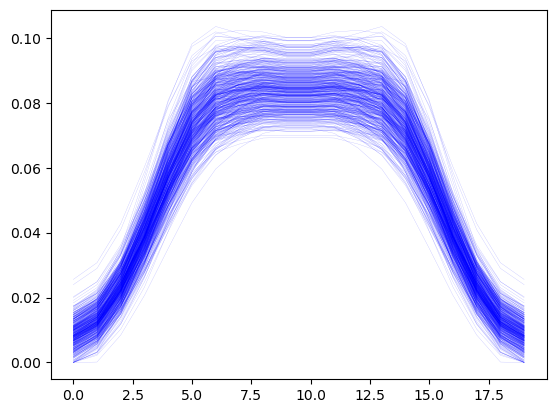

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(reloaded_results['MaxMuscleAct'].T, 'b', lw=0.2, alpha = 0.3);